In [1]:
import pandas as pd
import json
import numpy as np
from collections import Counter
import pickle
from tqdm import tqdm
import seaborn as sns
import collections

import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig ,DistilBertTokenizerFast, DistilBertForQuestionAnswering
from transformers import AutoModel, AutoTokenizer, AutoModelForQuestionAnswering

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import DistilBertModel, DistilBertConfig

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [2]:
class ermQA(torch.utils.data.Dataset):
    def __init__(self, filename):
        with open(f"processed_data/{filename}.pickle", "rb") as f:
            self.encodings = pickle.load(f)

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [3]:
class DistilBERTEncoder(torch.nn.Module):
    def __init__(self, frozen=True):
        super(DistilBERTEncoder, self).__init__()
        self.encoder = AutoModel.from_pretrained('dmis-lab/biobert-v1.1', output_hidden_states = True)
        self.encoder.to(device)
        if frozen:
            self.encoder.requires_grad = False
            self.encoder.eval()

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids, attention_mask = attention_mask)
        embedding = output.last_hidden_state # [batch, 512, 3072]

        return embedding
    
    
class SimpleReader(torch.nn.Module):
    def __init__(self, in_features=768, out_features=1):
        super(SimpleReader, self).__init__()
        self.encoder = DistilBERTEncoder(frozen=False)
        self.linear = nn.Linear(in_features=in_features, out_features=out_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        embeddings = self.encoder(input_ids, attention_mask = attention_mask)
        embedding_first_token = torch.squeeze(embeddings[:, 0, :], axis = 1) # [batch, 3072]    
        linear = self.linear(embedding_first_token) # [batch, 1] 
        logit = self.sigmoid(linear)  # [batch, 1]   
        return logit
    
class DeepReader(torch.nn.Module):
    def __init__(self, embed_size=768, num_heads=1):
        super(DeepReader, self).__init__()
        self.encoder = DistilBERTEncoder(frozen=False)
        
        # Self attention on passage 
        self.passage_key_linear = nn.Linear(embed_size, embed_size)
        self.passage_value_linear = nn.Linear(embed_size, embed_size)
        self.passage_query_linear = nn.Linear(embed_size, embed_size)
        self.passage_attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, batch_first=True)

        # Self attention on question 
        self.question_key_linear = nn.Linear(embed_size, embed_size)
        self.question_value_linear = nn.Linear(embed_size, embed_size)
        self.question_query_linear = nn.Linear(embed_size, embed_size)
        self.question_attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, batch_first=True)

        # Cross attention 
        self.cross_query_linear = nn.Linear(embed_size, embed_size)
        self.cross_key_linear = nn.Linear(embed_size, embed_size)
        self.cross_value_linear = nn.Linear(embed_size, embed_size)
        self.cross_attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, batch_first=True)

        # Feed forward neural network (FFN)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, 2)
        )
    
    def forward(self, input_ids, attention_mask):
        embeddings = self.encoder(input_ids, attention_mask = attention_mask)
        
        token_split_index = self.generate_token_split_index(input_ids)

        passage, question = torch.tensor_split(embeddings, token_split_index, dim=1)

        passage_key = self.passage_key_linear(passage)
        passage_value = self.passage_value_linear(passage)
        passage_query = self.passage_query_linear(passage)
        passage_after_attention, _ = self.passage_attention(query=passage_query, key=passage_key, value=passage_value)

        question_key = self.question_key_linear(question)
        question_value = self.question_value_linear(question)
        question_query = self.question_query_linear(question)
        question_after_attention, _ = self.question_attention(query=question_query, key=question_key, value=question_value)

        cross_query = self.cross_query_linear(passage_after_attention)
        cross_key = self.cross_key_linear(question_after_attention)
        cross_value = self.cross_value_linear(question_after_attention)
        cross_attention_embedding, _ = self.cross_attention(query=cross_query, key=cross_key, value=cross_value)

        ffn_output = self.linear_relu_stack(cross_attention_embedding)
        output = nn.functional.softmax(ffn_output, dim=1)

        return output
    
    def generate_token_split_index(self, input_ids):
        token_split_index = []
        sep_tokens = (input_ids == 102).nonzero(as_tuple=True)
        used_samples = set()
        for i, index in zip(sep_tokens[0], sep_tokens[1]):
            if i.item() not in used_samples:
                token_split_index.append(index.item())
                used_samples.add(i.item())
        return token_split_index

# Inference

In [4]:
def compute_exact_match(prediction, truth):
    exact_match = 0
    for pred, tru in zip(prediction, truth):
        if pred == tru:
            exact_match += 1
    return exact_match / len(prediction)


def getOverlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))


def compute_tav_fast(start_logit, end_logit):
    start_probs, end_probs = (torch.softmax(start_logit, dim=0), torch.softmax(end_logit, dim=0))
    n = len(start_logit)
    s_null = start_probs[0] + end_probs[0]
    s_has = 0
    best_span = (0, 0)
    high_start_idx = 1
  
    for i in range(1, n):
        if start_probs[i] > start_probs[high_start_idx]:
            high_start_idx = i
        if start_probs[high_start_idx] + end_probs[i] > s_has:
            s_has = start_probs[high_start_idx] + end_probs[i]
            best_span = (high_start_idx, i)
            
    s_diff = s_null - s_has
    return s_diff.item(), best_span

def compute_s_ext(sr_logit):
    s_ext =  1 - 2*sr_logit.item()
    return s_ext

def compute_rv(sr_logit, start_logit, end_logit, weight=.5):
    s_ext = compute_s_ext(sr_logit)
    s_diff, best_span = compute_tav_fast(start_logit, end_logit)
    rv = weight * s_diff + (1-weight) * s_ext
    return rv, best_span

def compute_f1(prediction, truth, input_id_list):
    
    f1_scores = []
    
    for i, (pred, gold) in enumerate(zip(prediction, truth)):
        
        if pred == gold:
            f1_scores.append(1)
            
        else:
            pred_tokens = input_id_list[i-1][pred[0]: pred[1]+1]
            gold_tokens = input_id_list[i-1][gold[0]: gold[1]+1]

            total_overlap = len(set(pred_tokens).intersection(set(gold_tokens)))
            total_tru = len(gold_tokens)
            total_pred = len(pred_tokens)

            if len(pred_tokens) == 0 or len(gold_tokens) == 0:
                f1_scores.append(int(pred_tokens == gold_tokens))
            elif total_overlap == 0:
                f1_scores.append(0)
            else:
                prec = total_overlap / total_pred
                rec = total_overlap / total_tru
                f1_scores.append(2 * (prec * rec) / (prec + rec))
    
    return np.mean(f1_scores)

In [5]:
def generate_predictions(simple_model, deep_model, data_loader, dataset, split):
    truths = []
    
    # Greedy
    spans_greedy = []
    
    # RV
    rvs = []
    spans_rv = []
    
    input_id_list = []
    
    for batch in tqdm(data_loader):

        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # Truth Span
            for i, j, k in zip(batch['start_positions'], batch['end_positions'], batch['input_ids']):
                truths.append((i.item(), j.item()))
                input_id_list.append(k.tolist())
        
            # Predictions
            input_ids = torch.tensor(batch['input_ids']).to(device)
            attention_mask = torch.tensor(batch['attention_mask']).to(device)
            sr_out = simple_model(input_ids, attention_mask)
            dr_out = deep_model(input_ids, attention_mask)
            
            start_logits = dr_out.start_logits
            end_logits = dr_out.end_logits
            
            # Greedy
            for i in range(len(start_logits)):
                start, end = torch.argmax(start_logits[i, :], dim=0), torch.argmax(end_logits[i, :], dim=0)
                spans_greedy.append((start.item(), end.item()))
            
            # RV
            for i, j, k in zip(sr_out, start_logits, end_logits):
                rv, span = compute_rv(i, j, k, weight=.5)
                rvs.append(rv)
                spans_rv.append(span)
    
    predictions_metadata = {
        'truth': truths,
        'spans_greedy': spans_greedy,
        'rvs': rvs,
        'spans_rv': spans_rv,
        'input_id_list': input_id_list
    }
    with open(f'predictions/EHReader/bioBERT_{dataset}_{split}.pickle', 'wb') as f:
        pickle.dump(predictions_metadata, f)
            
    return predictions_metadata


def evaluate_predictions(predictions_metadata, rv=False, threshold=-0.98, print_info=False):
    if not rv:
        spans_pred = predictions_metadata['spans_greedy']
    else:
        spans_pred = []
        for rv, span_rv in zip(predictions_metadata['rvs'], predictions_metadata['spans_rv']):
            if rv < threshold:
                spans_pred.append(span_rv)
            else:
                spans_pred.append((0, 0))
                
    em = compute_exact_match(spans_pred, predictions_metadata['truth'])
    f1 = compute_f1(spans_pred,  predictions_metadata['truth'], predictions_metadata['input_id_list'])
    
    if print_info:
        print(f'EM: {round(em*100, 1)}, F1: {round(f1*100, 1)}')
        
    return em, f1

# Models and Dataset

In [6]:
simple_model = torch.load('models/SimpleReader/m_1_uf_e_2_vl_0.1676.model')
with open('models/SimpleReader/m_1_uf_e_2_vl_0.1676_metadata.pickle', 'rb') as f:
    simple_metadata = pickle.load(f)
simple_model.to(device)
simple_model.eval()

deep_model = torch.load('models/bioBERT/m_1_uf_e_8_vl_0.7559.model')
with open('models/bioBERT/m_1_uf_e_8_vl_0.7559_metadata.pickle', 'rb') as f:
    deep_metadata = pickle.load(f)
deep_model.to(device)
deep_model.eval()


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [7]:
dataset = 'medication'
TEST_BATCH_SIZE = 32
test_dataset = ermQA(f'{dataset}_qa_bio_test')
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

In [8]:
test_predictions_metadata = generate_predictions(simple_model, deep_model, test_loader, dataset, 'test')

  0%|          | 0/378 [00:00<?, ?it/s]C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 378/378 [22:19<00:00,  3.54s/it]


In [9]:
em, f1 = evaluate_predictions(test_predictions_metadata, rv=False, print_info=True)

EM: 59.3, F1: 60.8


In [10]:
em_list = []
thresholds = []
for threshold in np.arange(-1.5, 1.5, .01):
    em, f1 = evaluate_predictions(test_predictions_metadata, rv=True, threshold=threshold, print_info=False)
    em_list.append(em)
    thresholds.append(threshold)

-0.07999999999999874
EM: 61.4, F1: 63.3


(0.6136739417989417, 0.633368762236497)

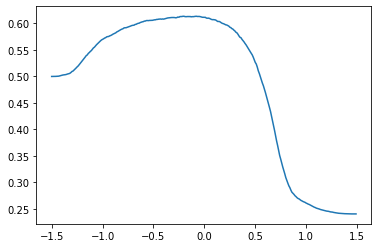

In [11]:
sns.lineplot(x=thresholds, y=em_list)
max_index = em_list.index(max(em_list))
threshold = thresholds[max_index]

print(threshold)
evaluate_predictions(test_predictions_metadata, rv=True, threshold=threshold, print_info=True)

In [12]:
TRAIN_BATCH_SIZE = 32
train_dataset = ermQA(f'{dataset}_qa_bio_train')
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False)

In [13]:
train_predictions_metadata = generate_predictions(simple_model, deep_model, train_loader, dataset, 'train')

  0%|          | 0/1134 [00:00<?, ?it/s]C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  3%|▎         | 31/1134 [01:51<1:06:14,  3.60s/it]


KeyboardInterrupt: 

In [ ]:
em, f1 = evaluate_predictions(train_predictions_metadata, rv=False, print_info=True)

In [ ]:
em_list = []
thresholds = []
for threshold in np.arange(-1.5, 1.5, .01):
    em, f1 = evaluate_predictions(train_predictions_metadata, rv=True, threshold=threshold, print_info=False)
    em_list.append(em)
    thresholds.append(threshold)

In [ ]:
sns.lineplot(x=thresholds, y=em_list)
max_index = em_list.index(max(em_list))
threshold = thresholds[max_index]

print(threshold)
evaluate_predictions(train_predictions_metadata, rv=True, threshold=-.54, print_info=True)